In [1]:
import sys
if 'google.colab' in sys.modules:
    !git clone  https://github.com/ecastillot/delaware.git ./delaware
    !pip install obspy

In [2]:
import sys
import os

version = "10102024"

if 'google.colab' in sys.modules:
    dw_path = os.path.join("/content/delaware",version)
else:
    dw_path = os.path.join("/home/emmanuel/ecastillo/dev/delaware",version)
    
sys.path.append(dw_path)

In [51]:
from delaware.core.read import EQPicks
from delaware.core.eqviewer import Stations
from delaware.loc.inv import prepare_cat2vps
import pandas as pd
import os
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations
from typing import Tuple, List, Dict
from scipy.stats import mode

def load_stations(stations_path: str, proj: str) -> object:
    """
    Load station data and return a Stations object.

    Args:
        stations_path (str): Path to the stations CSV file.
        proj (str): EPSG projection for the station data.

    Returns:
        Stations: An object containing station data.
    """
    stations = pd.read_csv(stations_path)
    stations_columns = ["network", "station", "latitude", "longitude", "elevation", "x[km]", "y[km]"]
    stations = stations[stations_columns]
    stations["station_index"] = stations.index
    stations_obj = Stations(data=stations, xy_epsg=proj)
    return stations_obj

def get_single_station(stations: object, station_name: str) -> pd.Series:
    """
    Extract information for a single station by name.

    Args:
        stations (object): Stations object containing station data.
        station_name (str): Name of the station to extract.

    Returns:
        pd.Series: Data for the specified station.
    """
    single_station = stations.data[stations.data["station"] == station_name].iloc[0]
    return single_station

def load_eqpicks(root: str, author: str, proj: str, catalog_path: str, picks_path: str) -> object:
    """
    Load earthquake picks and return an EQPicks object.

    Args:
        root (str): Root directory for the data.
        author (str): Author name for the picks.
        proj (str): EPSG projection for the picks.
        catalog_path (str): Path to the catalog CSV file.
        picks_path (str): Path to the picks database file.

    Returns:
        EQPicks: An object containing earthquake picks data.
    """
    return EQPicks(root, author=author, xy_epsg=proj, catalog_path=catalog_path, picks_path=picks_path)

def process_catalog_and_picks(eq_picks: object, single_station: pd.Series,
                              stations: Stations) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Process catalog and picks for a single station.

    Args:
        eq_picks (object): EQPicks object containing picks and catalog data.
        single_station (pd.Series): Data for a single station.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Processed catalog and picks data.
    """
    src = (single_station.latitude, single_station.longitude, 1, None)
    catalog, picks = eq_picks.get_catalog_with_picks(region_from_src=src)
    catalog, picks = prepare_cat2vps(catalog.data, picks.data, stations.data)
    picks = picks[picks["station"] == single_station.station]
    catalog = catalog[catalog['ev_id'].isin(picks['ev_id'])]
    return catalog, picks

def preprocess_picks(picks: pd.DataFrame, catalog: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess picks data by merging with catalog and calculating arrival times.

    Args:
        picks (pd.DataFrame): Picks data.
        catalog (pd.DataFrame): Catalog data.

    Returns:
        pd.DataFrame: Preprocessed picks data.
    """
    picks_data = pd.merge(picks, catalog, on=["ev_id"])
    picks_data['arrival_time_P'] = pd.to_datetime(picks_data['arrival_time_P']) - pd.to_datetime(picks_data['origin_time'])
    picks_data['arrival_time_S'] = pd.to_datetime(picks_data['arrival_time_S']) - pd.to_datetime(picks_data['origin_time'])
    picks_data['arrival_time_P'] = picks_data['arrival_time_P'].apply(lambda x: x.total_seconds())
    picks_data['arrival_time_S'] = picks_data['arrival_time_S'].apply(lambda x: x.total_seconds())
    return picks_data

def calculate_vij(picks_data: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate v_ij for all combinations of picks.

    Args:
        picks_data (pd.DataFrame): Preprocessed picks data.

    Returns:
        pd.DataFrame: DataFrame containing v_ij results.
    """
    results = []
    good_logs, bad_logs = [], []

    for i, j in combinations(picks_data.index, 2):
        delta_t_S = picks_data.loc[i, 'arrival_time_S'] - picks_data.loc[j, 'arrival_time_S']
        delta_t_P = picks_data.loc[i, 'arrival_time_P'] - picks_data.loc[j, 'arrival_time_P']
        v_ij = delta_t_S / delta_t_P if delta_t_P != 0 else None

        log = {
            "ev_i": picks_data.loc[i, 'ev_id'],
            "ev_j": picks_data.loc[j, 'ev_id'],
            "station": picks_data.loc[i, 'station'],
            "v_ij": v_ij
        }

        if v_ij is not None and v_ij > 0:
            results.append(log)
            good_logs.append(log)
        else:
            bad_logs.append(log)

    print(f"Good: {len(good_logs)}, Bad: {len(bad_logs)}")
    return pd.DataFrame(results)

def plot_vij_histogram(vij_df, station,bins=20,output=None):
    """
    Plots a histogram of the v_ij values.

    Parameters:
        vij_df (pd.DataFrame): DataFrame containing v_ij values.
        bins (int): Number of bins for the histogram.
    """
    # Extract v_ij values
    v_ij_values = vij_df['v_ij']
    # Calculate statistics
    median = v_ij_values.median()
    mean = v_ij_values.mean()
    # Create histogram with custom bins and calculate the mode
    hist, bin_edges = np.histogram(v_ij_values, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
    mode_bin_index = np.argmax(hist)  # Index of the bin with the highest count
    mode_value = bin_centers[mode_bin_index]  # Mode value from histogram
    
    # Plot the histogram using Seaborn
    # plt.figure(figsize=(8, 5))
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    sns.histplot(v_ij_values, bins=bins, kde=True, 
                #  stat="density",
                line_kws={'linewidth':2},ax=ax,
                 color='lightcoral', edgecolor='black')
    # ax.axvline(x=median,color="black",linestyle='dashed')
    
    # Add the median value as text near the red line
    # plt.text(median-0.005, plt.gca().get_ylim()[1] * 0.5, f"median {median:.2f}", 
    #          color="black", fontsize=12, ha='center', va='center', 
    #          rotation=90)
    # ax.text(0.95, 0.95, f"Median = {median:.2f}", 
    #          color="black", fontsize=12, ha='right', va='top', 
    #          transform=plt.gca().transAxes, 
    #         #  backgroundcolor="white"
    #          )
    # Add labels for the vertical lines
    # Add vertical lines for median, mean, and mode
    ax.axvline(x=median, color="black", linestyle="dashed", label=f"Median = {median:.2f}")
    ax.axvline(x=mean, color="blue", linestyle="dashed", label=f"Mean = {mean:.2f}")
    ax.axvline(x=mode_value, color="green", linestyle="dashed", label=f"Mode = {mode_value:.2f}")
    ax.set_xlim(min(bins),max(bins))
    
    # Add a legend in the upper right
    ax.legend(loc="upper right", fontsize=12)

    
    ax.grid(color='black', linewidth=0.5, linestyle=":")
    ax.minorticks_on()  # Enable minor ticks
    ax.grid(color='gray', linewidth=0.5, linestyle=":", which='minor')
    
    # Add labels and title
    ax.set_title(f"{station}", fontsize=16)
    ax.set_xlabel(r"${v_p}/{v_s}$", fontsize=14)
    ax.set_ylabel("Counts", fontsize=14)
    
    if output is not None:
        fig.savefig(output, dpi=300, bbox_inches='tight')
    plt.show()

['texnet2018hyse', 'texnet2018hzng', 'texnet2018hzpl', 'texnet2018iubu', 'texnet2018leko', 'texnet2018ntao', 'texnet2018qkyy', 'texnet2018squr', 'texnet2019ojmi', 'texnet2019ojsw', 'texnet2019xsnj', 'texnet2019ydse', 'texnet2019ydsw', 'texnet2020hgjr', 'texnet2020hgzi', 'texnet2020hhqg', 'texnet2020jtxc', 'texnet2020julz', 'texnet2020jwtw', 'texnet2020jyxx', 'texnet2020jyyf', 'texnet2020jzhs', 'texnet2020kcdb', 'texnet2020kcer', 'texnet2020qxpv', 'texnet2020rcmp', 'texnet2020skof', 'texnet2020vwmo', 'texnet2020vxzf', 'texnet2020vyxn', 'texnet2020wgwy', 'texnet2020whfo', 'texnet2020wilc', 'texnet2020wizt', 'texnet2020wobx', 'texnet2020wogt', 'texnet2020xeaw', 'texnet2020xjai', 'texnet2020xjir', 'texnet2020xjjh', 'texnet2020xmyy', 'texnet2020xtxl', 'texnet2020xvhn', 'texnet2020xvmj', 'texnet2020xwyl', 'texnet2020yeux', 'texnet2021agla', 'texnet2021ayvd', 'texnet2021coqs', 'texnet2021cufh', 'texnet2021cuia', 'texnet2021cuio', 'texnet2021cuip', 'texnet2021cuux', 'texnet2021cvau', 'texnet20

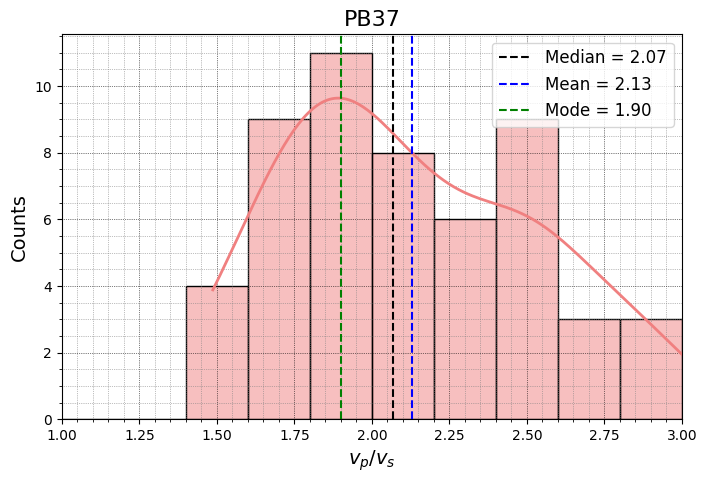

['texnet2017tjxk', 'texnet2018jmcn', 'texnet2018kvzw', 'texnet2018lxnk', 'texnet2018qhyp', 'texnet2018zbbj', 'texnet2019kefp', 'texnet2020dtqq', 'texnet2020oojy', 'texnet2020ucln', 'texnet2020wbgl', 'texnet2021bhvc', 'texnet2021bjcc', 'texnet2021bnjw', 'texnet2021brgs', 'texnet2021bzqz', 'texnet2021chbj', 'texnet2021coet', 'texnet2021cxhe', 'texnet2021dxbd', 'texnet2021dxbj', 'texnet2021dyhd', 'texnet2021fzqb', 'texnet2021gair', 'texnet2021ipvy', 'texnet2021iwto', 'texnet2021jbvw', 'texnet2021kamj', 'texnet2021kjej', 'texnet2021kjer', 'texnet2021klbb', 'texnet2021kwpm', 'texnet2021mxwz', 'texnet2021njdf', 'texnet2021qllt', 'texnet2021rtsx', 'texnet2021rwhf', 'texnet2021rwmw', 'texnet2021skmx', 'texnet2021sqao', 'texnet2021tqpa', 'texnet2021tsfi', 'texnet2021vfzy', 'texnet2021viul', 'texnet2021wpze', 'texnet2022bjdv', 'texnet2022bsbl', 'texnet2022bsrp', 'texnet2022cbwt', 'texnet2022ccfc', 'texnet2022cedz', 'texnet2022eeea', 'texnet2022ggky', 'texnet2022icbw', 'texnet2022lgeh', 'texnet20

/home/emmanuel/ecastillo/dev/delaware/10102024/delaware/core/database.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(all_dataframes, ignore_index=True)


Good: 1464, Bad: 366
                ev_i            ev_j station      v_ij
0     texnet2021dxbd  texnet2021dyhd    PB28  3.475935
1     texnet2021dxbd  texnet2021fzqb    PB28  0.914167
2     texnet2021dxbd  texnet2021ipvy    PB28  2.107120
3     texnet2021dxbd  texnet2021iwto    PB28  0.241524
4     texnet2021dxbd  texnet2021kjer    PB28  3.116109
...              ...             ...     ...       ...
1459  texnet2024akzc  texnet2024eljv    PB28  1.702821
1460  texnet2024akzc  texnet2024fxgw    PB28  1.847180
1461  texnet2024alrw  texnet2024eljv    PB28  0.950308
1462  texnet2024alrw  texnet2024fxgw    PB28  1.123206
1463  texnet2024eljv  texnet2024fxgw    PB28  3.732614

[1464 rows x 4 columns]
              v_ij
count  1170.000000
mean      2.060476
std       1.172795
min       0.528067
25%       1.209585
50%       1.757616
75%       2.580771
max       5.922499


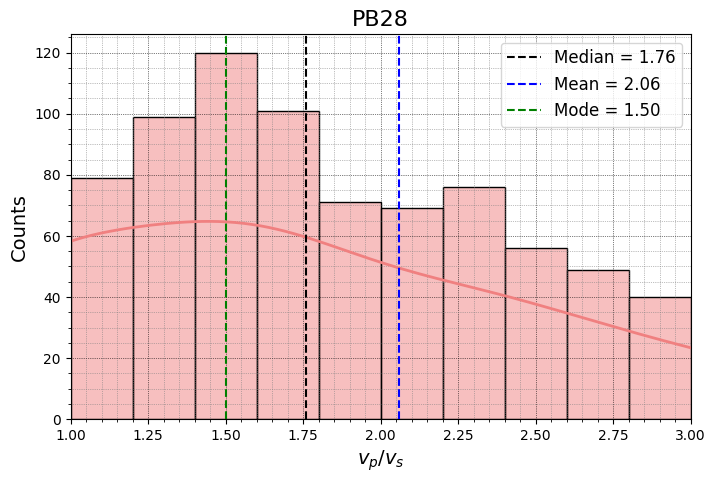

['texnet2020tuda', 'texnet2020vlis', 'texnet2020xnwq', 'texnet2020yusp', 'texnet2021aggr', 'texnet2021ajmh', 'texnet2021akmg', 'texnet2021bnub', 'texnet2021gqys', 'texnet2021lmgn', 'texnet2021qcxi', 'texnet2021rqnl', 'texnet2021rupe', 'texnet2021svbl', 'texnet2021uszg', 'texnet2021utpf', 'texnet2021vddq', 'texnet2021vgfv', 'texnet2021wmup', 'texnet2021xrsi', 'texnet2021yjee', 'texnet2021yppc', 'texnet2022bveq', 'texnet2022casu', 'texnet2022fddj', 'texnet2022fodb', 'texnet2022ghaf', 'texnet2022kyaq', 'texnet2022lbcm', 'texnet2022mzhi', 'texnet2023aqwf', 'texnet2023endh', 'texnet2023endk', 'texnet2023fawy', 'texnet2023fcap', 'texnet2023fcar', 'texnet2023fcne', 'texnet2023nsaz', 'texnet2023nxgc', 'texnet2023smgz', 'texnet2024gjfn', 'texnet2024gyrf']
9428 tables not found
Good: 60, Bad: 6
              ev_i            ev_j station       v_ij
0   texnet2023aqwf  texnet2023endh    PB35   2.183098
1   texnet2023aqwf  texnet2023endk    PB35   1.897849
2   texnet2023aqwf  texnet2023fawy    PB35

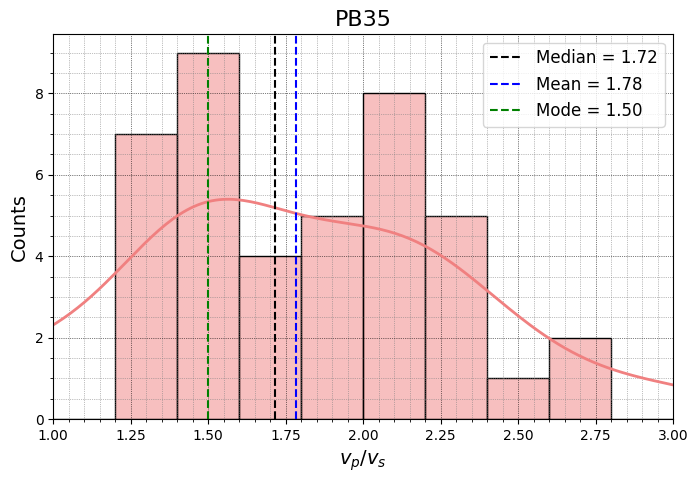

['texnet2018jxsj', 'texnet2018yzkl', 'texnet2019ktkw', 'texnet2020lbob', 'texnet2020oziz', 'texnet2020qqjg', 'texnet2020xpae', 'texnet2020xxaj', 'texnet2020yhjs', 'texnet2020yjht', 'texnet2020yjic', 'texnet2020yjih', 'texnet2020ypmn', 'texnet2021ayzc', 'texnet2021bphx', 'texnet2021bxsn', 'texnet2021byao', 'texnet2021cass', 'texnet2021cbvj', 'texnet2021cqsi', 'texnet2021dohv', 'texnet2021dtrb', 'texnet2021dweh', 'texnet2021ebyy', 'texnet2021edqb', 'texnet2021eevo', 'texnet2021fzhc', 'texnet2021hdbx', 'texnet2021hghu', 'texnet2021jeqk', 'texnet2021jexa', 'texnet2021jext', 'texnet2021jgns', 'texnet2021johk', 'texnet2021loak', 'texnet2021mavy', 'texnet2021msby', 'texnet2021mvez', 'texnet2021mwrx', 'texnet2021nazw', 'texnet2021ndzl', 'texnet2021nsjx', 'texnet2021oajg', 'texnet2021qrjy', 'texnet2021shhf', 'texnet2021sthf', 'texnet2021uqxg', 'texnet2022afva', 'texnet2022brnk', 'texnet2022brpp', 'texnet2022cuht', 'texnet2022ebjh', 'texnet2022fxmt', 'texnet2022gwvk', 'texnet2022gzcf', 'texnet20

/home/emmanuel/ecastillo/dev/delaware/10102024/delaware/core/database.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(all_dataframes, ignore_index=True)


Good: 3602, Bad: 493
                ev_i            ev_j station       v_ij
0     texnet2023abeo  texnet2023bgyb    PB36  15.406655
1     texnet2023abeo  texnet2023coyp    PB36   0.574349
2     texnet2023abeo  texnet2023dkaa    PB36   0.129074
3     texnet2023abeo  texnet2023gzor    PB36   2.485203
4     texnet2023abeo  texnet2023iepj    PB36   1.935680
...              ...             ...     ...        ...
3597  texnet2024aeky  texnet2024aopl    PB36   0.940622
3598  texnet2024aeky  texnet2024aqqw    PB36   1.594206
3599  texnet2024aeky  texnet2024arsb    PB36   2.010707
3600  texnet2024aopl  texnet2024aqqw    PB36   1.800506
3601  texnet2024aopl  texnet2024arsb    PB36   2.440972

[3602 rows x 4 columns]
              v_ij
count  2880.000000
mean      1.672471
std       0.523227
min       0.729434
25%       1.300630
50%       1.640106
75%       1.968332
max       3.148324


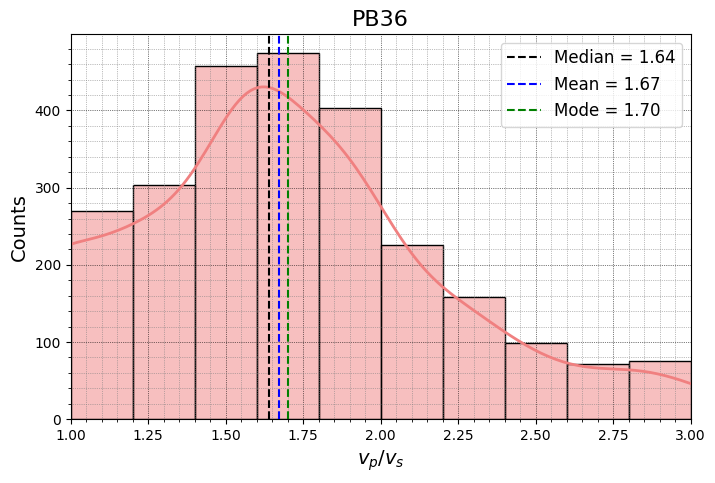

['texnet2020vexc', 'texnet2022duwl', 'texnet2022frzt', 'texnet2022owvx', 'texnet2022pasd', 'texnet2022tvbo']
9457 tables not found
Good: 1, Bad: 2
             ev_i            ev_j station      v_ij
0  texnet2022duwl  texnet2022frzt    SA02  1.074223
           v_ij
count  1.000000
mean   1.074223
std         NaN
min    1.074223
25%    1.074223
50%    1.074223
75%    1.074223
max    1.074223


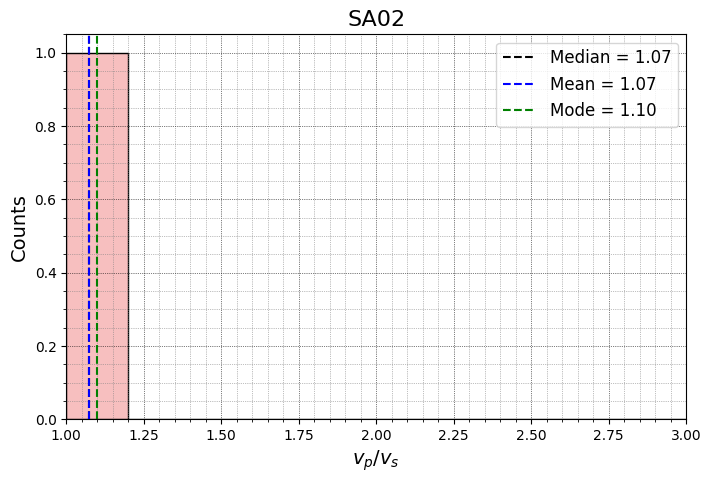

['texnet2021ngio', 'texnet2022adoj', 'texnet2022adxi', 'texnet2022aemp', 'texnet2022aepq', 'texnet2022jjsz', 'texnet2022xaxy', 'texnet2022xbch', 'texnet2023vxeo', 'texnet2023vzel', 'texnet2023wfzt', 'texnet2023xitt', 'texnet2023xmji', 'texnet2023xrlk', 'texnet2024ctvo']
9449 tables not found
Good: 18, Bad: 3
              ev_i            ev_j station      v_ij
0   texnet2023vxeo  texnet2023vzel    PB24  1.384384
1   texnet2023vxeo  texnet2023wfzt    PB24  1.205021
2   texnet2023vxeo  texnet2023xitt    PB24  1.291801
3   texnet2023vxeo  texnet2023xmji    PB24  1.456298
4   texnet2023vxeo  texnet2023xrlk    PB24  1.195581
5   texnet2023vxeo  texnet2024ctvo    PB24  1.218620
6   texnet2023vzel  texnet2023xitt    PB24  0.693475
7   texnet2023vzel  texnet2023xmji    PB24  1.591957
8   texnet2023vzel  texnet2023xrlk    PB24  0.886697
9   texnet2023wfzt  texnet2023xitt    PB24  3.040401
10  texnet2023wfzt  texnet2023xmji    PB24  2.099216
11  texnet2023wfzt  texnet2023xrlk    PB24  1.175263
1

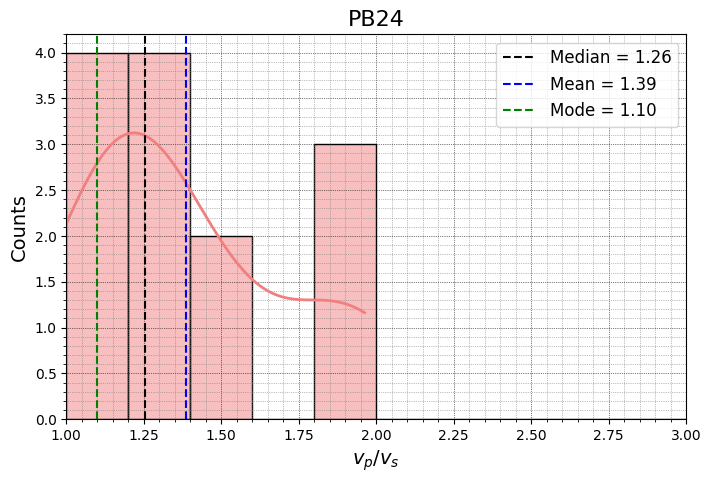

['texnet2020aqum', 'texnet2020bvzp', 'texnet2020cfpr', 'texnet2020dhix', 'texnet2020dhuz', 'texnet2020drsd', 'texnet2020dwna', 'texnet2020fona', 'texnet2020fscl', 'texnet2020fscs', 'texnet2020tuwq', 'texnet2020zsoe', 'texnet2021aeck', 'texnet2021aqeo', 'texnet2021aqhv', 'texnet2021aqmf', 'texnet2021axzn', 'texnet2021azsq', 'texnet2021bwhb', 'texnet2021cped', 'texnet2021flwp', 'texnet2021mkae', 'texnet2021mkfp', 'texnet2021mklo', 'texnet2021mkmg', 'texnet2021mkmj', 'texnet2021mkml', 'texnet2021mlis', 'texnet2021msla', 'texnet2021qpzy', 'texnet2021qviv', 'texnet2021skmk', 'texnet2021skmp', 'texnet2021sknv', 'texnet2021skom', 'texnet2021sksv', 'texnet2022fkqk', 'texnet2022fkrd', 'texnet2022fplw', 'texnet2022fpvv', 'texnet2022ftnq', 'texnet2022fzug', 'texnet2022gafq', 'texnet2022gapz', 'texnet2022gbdm', 'texnet2022gdfi', 'texnet2022gzqk', 'texnet2022hiqg', 'texnet2022ifjt', 'texnet2022ifkg', 'texnet2022ifnh', 'texnet2022ifsv', 'texnet2022igfu', 'texnet2022ihbu', 'texnet2022ikgk', 'texnet20

/home/emmanuel/ecastillo/dev/delaware/10102024/delaware/core/database.py:105: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(all_dataframes, ignore_index=True)


Good: 17939, Bad: 1564
                 ev_i            ev_j station      v_ij
0      texnet2022mjfq  texnet2022otpf    WB03  1.340487
1      texnet2022mjfq  texnet2022rdgy    WB03  2.302087
2      texnet2022mjfq  texnet2022repm    WB03  1.007046
3      texnet2022mjfq  texnet2022spmk    WB03  1.449744
4      texnet2022mjfq  texnet2022sprg    WB03  2.095942
...               ...             ...     ...       ...
17934  texnet2024goob  texnet2024gpdi    WB03  1.508072
17935  texnet2024goob  texnet2024icyi    WB03  1.979747
17936  texnet2024gopp  texnet2024gpdi    WB03  1.457495
17937  texnet2024gopp  texnet2024icyi    WB03  1.875685
17938  texnet2024gpdi  texnet2024icyi    WB03  2.690439

[17939 rows x 4 columns]
               v_ij
count  14351.000000
mean       1.614028
std        0.353023
min        0.810544
25%        1.396046
50%        1.611210
75%        1.796191
max        2.654209


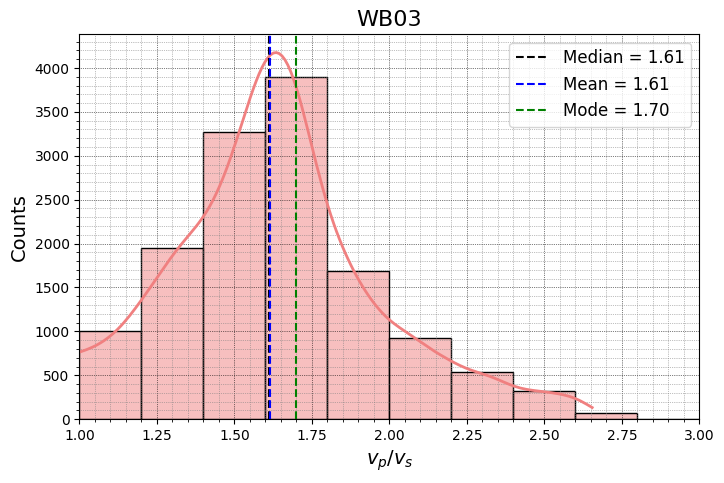

In [53]:
root = "/home/emmanuel/ecastillo/dev/delaware/10102024/data/eq/aoi/growclust"
catalog_path = "/home/emmanuel/ecastillo/dev/delaware/10102024/data/eq/aoi/growclust/origin.csv"
picks_path = "/home/emmanuel/ecastillo/dev/delaware/10102024/data/eq/aoi/growclust/picks.db"
author = "growclust"
proj = "EPSG:3857"
stations_path = "/home/emmanuel/ecastillo/dev/delaware/10102024/data_git/stations/standard_stations.csv"
bins = np.arange(1, 3.02, 0.2)
station_list = ["PB37","PB28","PB35","PB36","SA02","PB24","WB03"]
# station_list = ["WB03"]

for station_name in station_list:

    # station_name = "PB28"
    output_fig = os.path.join(f"/home/emmanuel/ecastillo/dev/delaware/10102024/figures/vps_station/vps_{station_name}.png")

    stations = load_stations(stations_path, proj)
    single_station = get_single_station(stations, station_name)

    # Load EQPicks
    eq_picks = load_eqpicks(root, author, proj, catalog_path, picks_path)

    # Process catalog and picks
    catalog, picks = process_catalog_and_picks(eq_picks, single_station,stations=stations)

    # Preprocess picks
    picks_data = preprocess_picks(picks, catalog)

    # Calculate v_ij
    results_df = calculate_vij(picks_data)
    print(results_df)

    Q1 = results_df['v_ij'].quantile(0.10)
    Q3 = results_df['v_ij'].quantile(0.90)
    iqr_results_df = results_df[(results_df['v_ij'] >= Q1) & (results_df['v_ij'] <= Q3)]
    print(iqr_results_df.describe())
    plot_vij_histogram(iqr_results_df,station_name,bins=bins,output=output_fig)


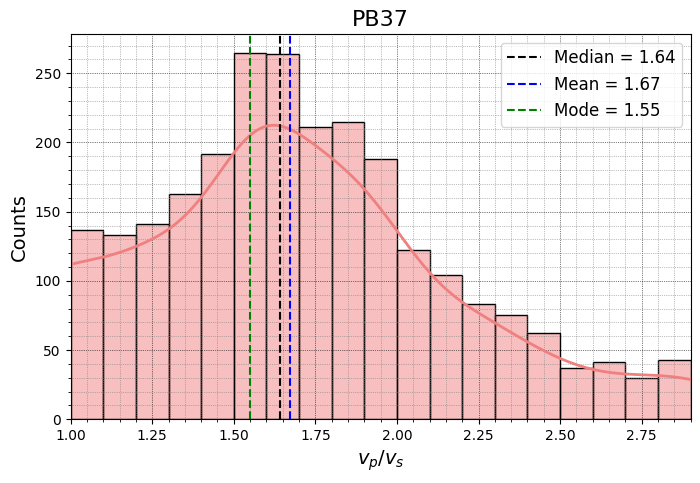

In [47]:
bins = np.arange(1, 3, 0.1)
plot_vij_histogram(iqr_results_df,station_name,bins=bins,output=output_fig)